In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import yfinance as yf
from pathlib import Path
from datetime import date
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler


Crear cartera equiponderada (sin rebalanceos) compuesta por: 
AAPL, AMZN, BAC, BRK-B, CVX, ENPH, GLD, GME, GOOGL, JNJ, JPM, MSFT, NVDA, PG, XOM, bono del gobierno americano a 10 años, bono del gobierno americano a 2 años y HYG (BAMLH0A0HYM2). 

Fase 1: Detectando el 'Pulso' del Mercado (Hidden Markov Models) 
Objetivo: Considerando la existencia de dos estados de mercado (calma y crisis), identifica, 
para cada día, en qué estado se encuentra el mercado. 
• Tarea  Técnica:  Ajustar  un  modelo  Gaussian  HMM  (Hidden  Markov  Model)  de  2 
estados sobre la serie de retornos multivariante y/o sobre factores representativos. 
• Output Visual: Gráfico del S&P 500 coloreado según el régimen detectado (Blanco = 
Calma, Azul = Crisis).

In [3]:
import sys
print(sys.executable)

/Users/emiliosanchez/Desktop/taller_riesgos/Practica-MIAX-gestion-de-riesgos/taller_riesgos_venv/bin/python


In [4]:
date_init = '2005-12-01'
symbols = ['AAPL','AMZN','BAC','BRK-B','CVX','ENPH','GLD','GME','GOOGL','JNJ','JPM','MSFT','NVDA','PG','XOM']
bons = ['DGS10', 'DGS2']
hyg = 'BAMLH0A0HYM2'

In [5]:
# descargar precios ajustados desde Yahoo hasta hoy
end = pd.Timestamp.today().normalize()
sp500 = yf.download('^GSPC', start=date_init, end=end, auto_adjust=True, progress=False)

if isinstance(sp500.columns, pd.MultiIndex):
     sp500.columns = sp500.columns.get_level_values(0)

sp500.index.name = None

# normalizar columnas
sp500 = sp500.rename(columns=str.lower).reset_index()
sp500 = sp500.rename(columns={'index': 'date'})
# calcular retornos
sp500['ret_close'] = sp500['close'].pct_change().dropna()

# quedarnos solo con las 3 columnas deseadas
returns = sp500[['date', 'ret_close']].dropna().copy()

returns.head()




Price,date,ret_close
1,2005-12-02,0.000324
2,2005-12-05,-0.002363
3,2005-12-06,0.001276
4,2005-12-07,-0.005009
5,2005-12-08,-0.001217


El ratio de Amihud captura cuánto se mueve el precio por unidad de volumen negociado:
Amihud_t = |R_t| / Volumen_t
- Si el precio cambia mucho con poco volumen → mercado ilíquido → Amihud alto
- Si el precio cambia poco con mucho volumen → mercado líquido → Amihud bajo
SPY es uno de los activos más líquidos del mundo, así que sus valores de Amihud son extremadamente bajos.

USAR COMO FEATURE DE LIQUIDEZ EM HMM

In [6]:
spy = yf.download('SPY', start=date_init, end=end, auto_adjust=True, progress=False)
spy = spy.rename(columns=str.lower)
spy.index.name = 'date'

spy_ret = spy['close'].pct_change().dropna()

spy_vol = spy['volume']

amihud_spy = (spy_ret['spy'].abs() / spy_vol['spy']).to_frame(name='amihud_sp500')
amihud_spy = amihud_spy.reset_index() 
amihud_spy.head()

,date,amihud_sp500
0,2005-12-01,NaN
1,2005-12-02,2.706312e-11
2,2005-12-05,3.591848e-11
3,2005-12-06,3.273285e-11
4,2005-12-07,8.733311e-11


CONEXIÓN CON LA FRED PARA BAJAR DATOS

In [7]:
BASE_URL = 'https://fred.stlouisfed.org/graph/fredgraph.csv?id='

def download_fred(serie):
    '''
    Descarga cualquier serie de FRED usando solo pandas.
    serie: código de la serie en FRED (ej: 'DGS10', 'DGS2', 'VIXCLS')
    '''
    url = BASE_URL + serie
    df = pd.read_csv(url)

    # FRED usa 'observation_date' como nombre de columna cambio por 'date' y convertir a datetime
    df.rename(columns={'observation_date': 'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])

    # Filtrar por fecha de inicio date_init
    df = df[df['date'] >= pd.to_datetime(date_init)]


    # Calcular cambio diario
    df[f'{serie}_change'] = df[serie].diff()

    return df


Descarga del Vix:
VIX < 15: Mercado tranquilo
VIX 15-25: Volatilidad normal
VIX 25-35: Nerviosismo
VIX > 35: Pánico/crisis

In [8]:
vixcls = download_fred('VIXCLS')
vixcls.head()


,date,VIXCLS,VIXCLS_change
4152,2005-12-01,11.24,NaN
4153,2005-12-02,11.01,-0.23
4154,2005-12-05,11.60,0.59
4155,2005-12-06,11.52,-0.08
4156,2005-12-07,12.18,0.66


Bono USA 10 años

In [9]:
dgs10 = download_fred('DGS10')
dgs10.head()

,date,DGS10,DGS10_change
11457,2005-12-01,4.52,NaN
11458,2005-12-02,4.52,0.00
11459,2005-12-05,4.57,0.05
11460,2005-12-06,4.49,-0.08
11461,2005-12-07,4.52,0.03


Bono USA 2 años

In [10]:
dgs2 = download_fred('DGS2')
dgs2.head()

,date,DGS2,DGS2_change
7697,2005-12-01,4.45,NaN
7698,2005-12-02,4.43,-0.02
7699,2005-12-05,4.47,0.04
7700,2005-12-06,4.42,-0.05
7701,2005-12-07,4.42,0.00


Bonos high yield

In [11]:
hy_oas = download_fred('BAMLH0A0HYM2')
hy_oas.head()

,date,BAMLH0A0HYM2,BAMLH0A0HYM2_change
2357,2005-12-01,3.62,NaN
2358,2005-12-02,3.63,0.01
2359,2005-12-05,3.62,-0.01
2360,2005-12-06,3.68,0.06
2361,2005-12-07,3.66,-0.02


Nos gustaría usar el PMI, pero no es fácil de obtener:

Uso Chicago PMI com proxy porque no esta disponible PMI desde 2003. 
CFNAI =  Chicago Fed National Activity Index. 
Es un idice de 85 indicadores económocos de EEUU. Su objetivo es medir si la economía está por encima de la tendencia histórica o por debajo. Si su valor es menor a  -0.7 es una clara señal de recesión. La versión MA3, es la media movila a 3 meses, se usa en análisis macro porque es más estable y menos ruidosa. 

Calma-> valores cercanos a 0 
Crisis -> Valores menores de -0.7



-Por qué la usamos?-> Gratis y fácil de obtener, Alta correlación con el PMI , además el PMI calcula toda la economía, no solo la manufacturera

In [12]:
pmi = download_fred('CFNAIMA3')
pmi_daily = (
    pmi
    .set_index("date")
    .resample("D")
    .ffill()
    .reset_index()
)

pmi_daily.head() #Todos los datos de diceimbre 2005 salen a NaN, pero los datos de enero 2006 ya están completos, por lo que no hay problema.

,date,CFNAIMA3,CFNAIMA3_change
0,2005-12-01,0.57,NaN
1,2005-12-02,0.57,NaN
2,2005-12-03,0.57,NaN
3,2005-12-04,0.57,NaN
4,2005-12-05,0.57,NaN



CONSUMER PRICE INDEX

CPI es una medida mensual, indica los indice de precios de consumo, la pérdida o ganancia de poder adquisitivo de los hogares

cpi_daily = cpi.set_index("date").resample("D").ffill().reset_index()

El CPI es una cantidad que en el 84 se normalizó a 100. Lo que nos da es un valor. la variación de ete CPI es la inflación



In [13]:
cpi = download_fred('CPIAUCSL')
cpi_daily = (
    cpi
    .set_index("date")
    .resample("D")
    .ffill()
    .reset_index()
)

cpi_daily.head() #Todos los datos de diciembre 2005 salen a NaN, pero los datos de enero 2006 ya están completos, por lo que no hay problema.


,date,CPIAUCSL,CPIAUCSL_change
0,2005-12-01,198.1,NaN
1,2005-12-02,198.1,NaN
2,2005-12-03,198.1,NaN
3,2005-12-04,198.1,NaN
4,2005-12-05,198.1,NaN


Unemployment Rate->Porcentaje de fuerza laboral que está desempleada (El paro de USA)

se considera una crisis severa unas tasas de paro superiores al 8% y señal de debilidad por encima del 6%

In [14]:
unrate = download_fred('UNRATE')

unrate_daily = (
    unrate
    .set_index("date")
    .resample("D")
    .ffill()
    .reset_index()
)

unrate_daily.head() #Todos los datos de diceimbre 2005 salen a NaN, pero los datos de enero 2006 ya están completos, por lo que no hay problema.

,date,UNRATE,UNRATE_change
0,2005-12-01,4.9,NaN
1,2005-12-02,4.9,NaN
2,2005-12-03,4.9,NaN
3,2005-12-04,4.9,NaN
4,2005-12-05,4.9,NaN


El Put/Call Ratio mide el volumen relativo de opciones put frente a opciones call.
Es uno de los indicadores de sentimiento más usados:
- MAyor que 2 -> Pánico
- Mayor que 1.0 → sentimiento bajista (más puts que calls)
- Menos que 0.7 → sentimiento alcista (más calls que puts)
- Entre 0.7 y 1.0 → neutral

El VIX comple una función muy similar


Cálculo del DF final con todos los elementos que hemos descargado:



In [15]:
df_final = (
    returns
    .merge(sp500[['date', 'close']], on='date', how='left')
    .merge(amihud_spy[['date', 'amihud_sp500']], on='date', how='left')
    .merge(vixcls[['date','VIXCLS', 'VIXCLS_change']], on='date', how='left')
    .merge(dgs10[['date', 'DGS10', 'DGS10_change']], on='date', how='left')
    .merge(dgs2[['date', 'DGS2', 'DGS2_change']], on='date', how='left')
    .merge(hy_oas[['date','BAMLH0A0HYM2', 'BAMLH0A0HYM2_change']], on='date', how='left')
    .merge(pmi_daily[['date', 'CFNAIMA3_change']], on='date', how='left')
    .merge(cpi_daily[['date', 'CPIAUCSL_change']], on='date', how='left')
    .merge(unrate_daily[['date', 'UNRATE_change']], on='date', how='left')
)
df_final = df_final[df_final['date'] >= '2006-01-01']
df_final.head(500)


,date,ret_close,close,amihud_sp500,VIXCLS,VIXCLS_change,DGS10,DGS10_change,DGS2,DGS2_change,BAMLH0A0HYM2,BAMLH0A0HYM2_change,CFNAIMA3_change,CPIAUCSL_change,UNRATE_change
20,2006-01-03,0.016430,1268.800049,2.400940e-10,11.14,NaN,4.37,NaN,4.34,NaN,3.73,NaN,-0.05,1.200,-0.2
21,2006-01-04,0.003673,1273.459961,9.125241e-11,11.37,0.23,4.36,-0.01,4.31,-0.03,3.69,-0.04,-0.05,1.200,-0.2
22,2006-01-05,0.000016,1273.479980,1.328499e-11,11.31,-0.06,4.36,0.00,4.32,0.01,3.64,-0.05,-0.05,1.200,-0.2
23,2006-01-06,0.009399,1285.449951,1.323262e-10,11.00,-0.31,4.38,0.02,4.36,0.04,3.56,-0.08,-0.05,1.200,-0.2
24,2006-01-09,0.003656,1290.150024,5.902339e-11,11.13,0.13,4.38,0.00,4.36,0.00,3.51,-0.05,-0.05,1.200,-0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,2007-12-20,0.004900,1460.119995,2.935587e-11,20.58,-1.10,4.04,-0.02,3.09,-0.03,5.79,0.08,-0.13,0.611,0.3
516,2007-12-21,0.016670,1484.459961,9.868065e-11,18.47,-2.11,4.18,0.14,3.19,0.10,5.68,-0.11,-0.13,0.611,0.3
517,2007-12-24,0.008077,1496.449951,1.628507e-10,18.60,0.13,4.23,0.05,3.24,0.05,5.65,-0.03,-0.13,0.611,0.3
518,2007-12-26,0.000809,1497.660034,3.195253e-11,18.66,NaN,4.30,NaN,3.31,NaN,5.59,NaN,-0.13,0.611,0.3


Creamos features adicionales: resta de los tipos a 10 y 2 años y cambio de esta resta


In [16]:
df_final['yield_curve'] = df_final['DGS10'] - df_final['DGS2']

# Cambio de la pendiente
df_final['yield_curve_change'] = df_final['yield_curve'].diff()

Con los datos obtenidos se procede a aplicar el modelo modelo  Gaussian  HMM. 

In [17]:
features = [
    'ret_close',                # 1. Retorno S&P
    'amihud_sp500',             # 2. Liquidez
    'VIXCLS',                   # 3. Nivel volatilidad (añadido)
    'VIXCLS_change',            # 4. Cambio volatilidad
    'yield_curve',              # 5. Pendiente curva tipos (añadido)
    'yield_curve_change',       # 6. Cambio pendiente
    'BAMLH0A0HYM2',            # 7. Nivel spread HY
    'BAMLH0A0HYM2_change',     # 8. Cambio spread HY
    'CFNAIMA3_change',         # 9. Actividad económica
    'CPIAUCSL_change',         # 10. Inflación
    'UNRATE_change'            # 11. Desempleo
]
df_final = df_final.sort_values("date").set_index("date")

df_final = df_final.bfill() #sustituye los valores faltantes anteriores
df_final = df_final.ffill() #sustituye los valores faltantes posteriores

df_final = df_final.reset_index()

df_to_HMM = df_final[features].values

Normalizamos todos los valores que tenemos en nuestro df 

In [18]:
scaler = StandardScaler()

# Ajustar y transformar
df_to_HMM_scaled = scaler.fit_transform(df_to_HMM)

Aplicamos el Gausian HMM

In [19]:
model = GaussianHMM(
    n_components=2,        # número de regímenes Calma/Crisis
    covariance_type='full',
    n_iter=500,
    random_state=42
)

model.fit(df_to_HMM_scaled)


,n_components,2
,covariance_type,'full'
,min_covar,0.001
,startprob_prior,1.0
,transmat_prior,1.0
,means_prior,0
,means_weight,0
,covars_prior,0.01
,covars_weight,1
,algorithm,'viterbi'
,random_state,42


In [22]:
df_final["regime"] = model.predict(df_to_HMM_scaled)

In [23]:
stats = df_final.groupby("regime")["ret_close"].agg(["mean", "std"])

stats["sharpe"] = stats["mean"] / stats["std"]
crisis_state = stats["sharpe"].idxmin()
calm_state   = stats["sharpe"].idxmax()
print(f"Crisis es {crisis_state}, Calma es {calm_state}")
print(f"Numero de días por estado: {df_final['regime'].value_counts()}")

Crisis es 0, Calma es 1
Numero de días por estado: regime
1    4315
0     741
Name: count, dtype: int64


In [24]:
df_final["regime_shift"] = df_final["regime"].diff().fillna(0).abs()
num_shifts = df_final["regime_shift"].sum()

print("Número de cambios de estado:", int(num_shifts))


Número de cambios de estado: 109


In [25]:
df_final["regime_run"] = (df_final["regime"] != df_final["regime"].shift()).cumsum() #contador para cambios de régimen
durations = df_final.groupby(["regime", "regime_run"]).size() #duración de cada período de régimen

durations



regime  regime_run
0       2               1
        4               4
        6               1
        8               1
        10              3
                     ... 
1       101            91
        103            68
        105            11
        107           108
        109            75
Length: 110, dtype: int64

In [26]:
durations.groupby(level=0).mean() #duración media de cada régimen


regime
0    13.472727
1    78.454545
dtype: float64

In [27]:
crisis_durations = durations.loc[crisis_state]

valid_runs = crisis_durations[crisis_durations > 3].index # MAYOR A 3 LO HE PUESTO SIN CRTITERIO; PARA ELIMINAR EPISODIOS MUY CORTOS QUE NO PARECEN CRISIS REALES


In [31]:
MIN_CRISIS_DAYS= 30

crisis_periods = []
current_start = None
current_run = None

for i in range(len(df_final)):
    regime = df_final["regime"].iloc[i]
    run_id = df_final["regime_run"].iloc[i]
    date = df_final["date"].iloc[i]

    if regime == crisis_state and run_id in valid_runs:
        if current_start is None:
            current_start = date
            current_run = run_id
    else:
         if current_start is not None:
          
            duration = (date - current_start).days
            if duration >= MIN_CRISIS_DAYS:  # Filtro por duración
                crisis_periods.append((current_start, date))
            current_start = None
            current_run = None

# Si termina dentro de un periodo válido
if current_start is not None:
    duration = (df_final["date"].iloc[-1] - current_start).days
    if duration >= MIN_CRISIS_DAYS:
        crisis_periods.append((current_start, df_final["date"].iloc[-1], duration))


for start, end in crisis_periods:
    print(start, "→", end)

print(f"Número de períodos de crisis(>30 días): {len(crisis_periods)}")


2008-09-02 00:00:00 → 2009-08-04 00:00:00
2020-02-27 00:00:00 → 2020-11-10 00:00:00
2021-01-27 00:00:00 → 2021-04-01 00:00:00
2021-05-03 00:00:00 → 2021-07-01 00:00:00
2022-04-26 00:00:00 → 2022-07-01 00:00:00
Número de períodos de crisis(>30 días): 5


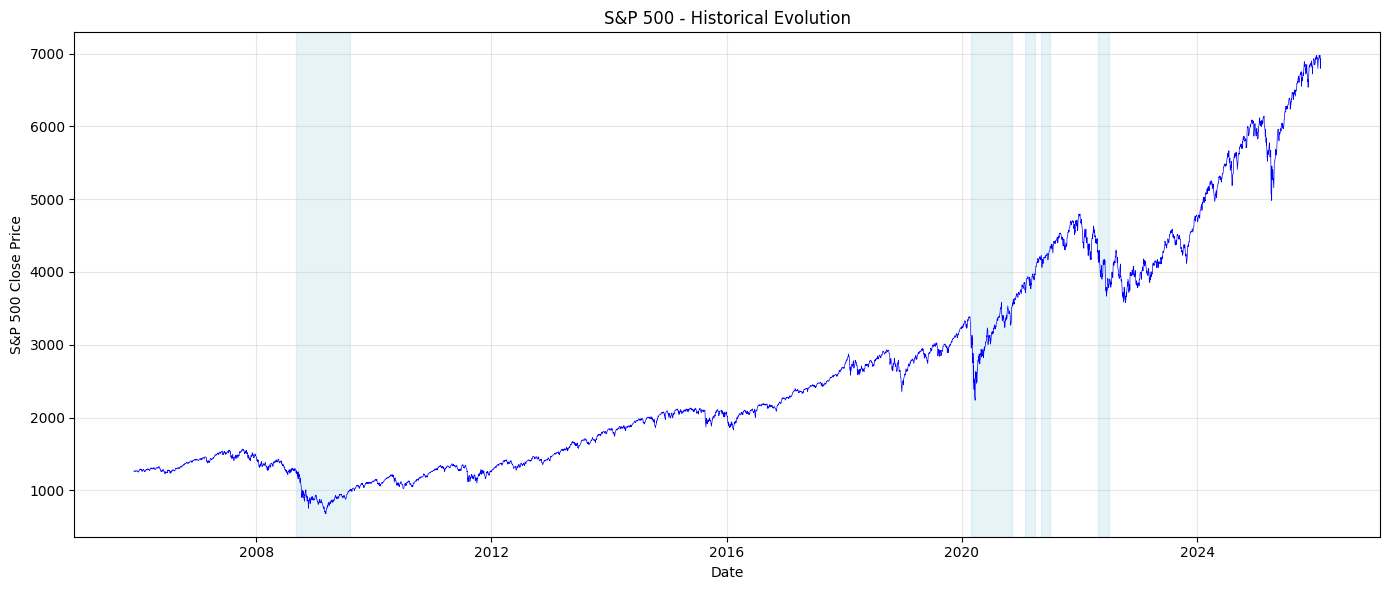

In [32]:
plt.figure(figsize=(14, 6))
plt.plot(sp500['date'], sp500['close'], linewidth=0.5, color='blue')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.title('S&P 500 - Historical Evolution')
plt.grid(True, alpha=0.3)

for start, end in crisis_periods:
    plt.axvspan(start, end, color='lightblue', alpha=0.3)

plt.tight_layout()
plt.show()

*Fase 2: Anatomía del Riesgo (Análisis Marginal)*

In [63]:
# Retornos diarios de la lista de symbols desde diciembre 2005 hasta hoy
df_symbols = yf.download(symbols, start='2006-01-01', end=end, auto_adjust=True)[["Close"]]

df_symbols = df_symbols.reset_index()
df_symbols = df_symbols.rename(columns={"Date": "date"})
df_symbols["date"] = pd.to_datetime(df_symbols["date"])

if isinstance(df_symbols.columns, pd.MultiIndex):
    new_cols = ["date"] + [col[1] for col in df_symbols.columns[1:]]
    df_symbols.columns = new_cols

df_symbols = df_symbols.sort_values("date").reset_index(drop=True)
df_returns_symbols = df_symbols.copy()
for s in symbols:
    df_returns_symbols[s] = df_symbols[s].pct_change()  
df_returns_symbols.head(5000)

[*********************100%***********************]  15 of 15 completed


,date,AAPL,AMZN,BAC,BRK-B,CVX,ENPH,GLD,GME,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM
0,2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-01-04,0.002943,-0.006936,-0.010620,0.000675,-0.002877,NaN,0.003389,0.035283,0.022999,0.015415,-0.005772,0.004844,0.027997,0.001872,0.001710
2,2006-01-05,-0.007870,0.008466,0.001288,-0.002359,-0.012223,NaN,-0.018011,0.115396,0.013476,-0.004155,0.003029,0.000741,0.022650,-0.003227,-0.004951
3,2006-01-06,0.025814,0.004617,-0.001501,0.003378,0.018217,NaN,0.026366,0.032431,0.031956,0.004493,0.007046,-0.002963,0.016426,-0.001022,0.019732
4,2006-01-09,-0.003277,-0.016503,0.000644,0.003030,-0.005063,NaN,0.016381,-0.004932,0.002663,0.006230,0.016241,-0.001859,0.027914,0.007504,-0.000505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4844,2025-04-04,-0.072887,-0.041534,-0.076034,-0.069073,-0.082244,-0.025523,-0.023392,0.113270,-0.033970,-0.041171,-0.074838,-0.035566,-0.073576,-0.050119,-0.071956
4845,2025-04-07,-0.036734,0.024912,0.034603,-0.006403,-0.021845,-0.026366,-0.021486,0.034057,0.007898,-0.017097,0.019783,-0.005502,0.035309,-0.021496,-0.013418
4846,2025-04-08,-0.049818,-0.026247,-0.015458,0.004609,-0.022975,-0.111908,0.005444,-0.037052,-0.013969,-0.004116,0.011332,-0.009221,-0.013724,-0.011483,-0.021080
4847,2025-04-09,0.153288,0.119770,0.060520,0.058400,0.066457,0.093094,0.036991,0.085934,0.096821,0.006467,0.080555,0.101337,0.187227,0.024812,0.049916


In [64]:
df_aut_risk = (
df_returns_symbols
    .merge(dgs10[['date', 'DGS10_change']], on='date', how='left')
    .merge(dgs2[['date', 'DGS2_change']], on='date', how='left')
    .merge(hy_oas[['date', 'BAMLH0A0HYM2_change']], on='date', how='left')
)
df_auto = df_aut_risk[df_aut_risk['date'] >= '2006-01-01']
df_auto.head(500)

,date,AAPL,AMZN,BAC,BRK-B,CVX,ENPH,GLD,GME,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM,DGS10_change,DGS2_change,BAMLH0A0HYM2_change
0,2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-01-04,0.002943,-0.006936,-0.010620,0.000675,-0.002877,NaN,0.003389,0.035283,0.022999,0.015415,-0.005772,0.004844,0.027997,0.001872,0.001710,-0.01,-0.03,-0.04
2,2006-01-05,-0.007870,0.008466,0.001288,-0.002359,-0.012223,NaN,-0.018011,0.115396,0.013476,-0.004155,0.003029,0.000741,0.022650,-0.003227,-0.004951,0.00,0.01,-0.05
3,2006-01-06,0.025814,0.004617,-0.001501,0.003378,0.018217,NaN,0.026366,0.032431,0.031956,0.004493,0.007046,-0.002963,0.016426,-0.001022,0.019732,0.02,0.04,-0.08
4,2006-01-09,-0.003277,-0.016503,0.000644,0.003030,-0.005063,NaN,0.016381,-0.004932,0.002663,0.006230,0.016241,-0.001859,0.027914,0.007504,-0.000505,0.00,0.00,-0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2007-12-20,0.022335,0.013426,-0.004328,-0.008263,0.012651,NaN,-0.007193,0.018534,0.018188,0.000149,-0.014779,0.020983,0.020900,0.002878,0.007656,-0.02,-0.03,0.08
496,2007-12-21,0.035789,0.007507,0.012316,0.007656,0.021619,NaN,0.018177,-0.010467,0.010149,0.010396,0.018001,0.015203,-0.000284,0.012160,0.014111,0.14,0.10,-0.11
497,2007-12-24,0.025218,-0.002739,0.008588,0.014525,0.004678,NaN,0.000499,0.030106,0.005799,-0.002351,0.016323,0.014420,0.017634,-0.001890,0.002462,0.05,0.05,-0.03
498,2007-12-26,0.000755,0.020218,0.000473,0.006608,0.003810,NaN,0.017220,-0.006635,0.014428,-0.004568,0.002453,0.000820,0.013415,0.001352,0.012278,NaN,NaN,NaN


In [65]:
df_analysis = df_auto.merge(df_final[["date", "regime"]], on="date", how="left")
df_analysis.head(500)

,date,AAPL,AMZN,BAC,BRK-B,CVX,ENPH,GLD,GME,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM,DGS10_change,DGS2_change,BAMLH0A0HYM2_change,regime
0,2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2006-01-04,0.002943,-0.006936,-0.010620,0.000675,-0.002877,NaN,0.003389,0.035283,0.022999,0.015415,-0.005772,0.004844,0.027997,0.001872,0.001710,-0.01,-0.03,-0.04,0
2,2006-01-05,-0.007870,0.008466,0.001288,-0.002359,-0.012223,NaN,-0.018011,0.115396,0.013476,-0.004155,0.003029,0.000741,0.022650,-0.003227,-0.004951,0.00,0.01,-0.05,0
3,2006-01-06,0.025814,0.004617,-0.001501,0.003378,0.018217,NaN,0.026366,0.032431,0.031956,0.004493,0.007046,-0.002963,0.016426,-0.001022,0.019732,0.02,0.04,-0.08,0
4,2006-01-09,-0.003277,-0.016503,0.000644,0.003030,-0.005063,NaN,0.016381,-0.004932,0.002663,0.006230,0.016241,-0.001859,0.027914,0.007504,-0.000505,0.00,0.00,-0.05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2007-12-20,0.022335,0.013426,-0.004328,-0.008263,0.012651,NaN,-0.007193,0.018534,0.018188,0.000149,-0.014779,0.020983,0.020900,0.002878,0.007656,-0.02,-0.03,0.08,0
496,2007-12-21,0.035789,0.007507,0.012316,0.007656,0.021619,NaN,0.018177,-0.010467,0.010149,0.010396,0.018001,0.015203,-0.000284,0.012160,0.014111,0.14,0.10,-0.11,0
497,2007-12-24,0.025218,-0.002739,0.008588,0.014525,0.004678,NaN,0.000499,0.030106,0.005799,-0.002351,0.016323,0.014420,0.017634,-0.001890,0.002462,0.05,0.05,-0.03,0
498,2007-12-26,0.000755,0.020218,0.000473,0.006608,0.003810,NaN,0.017220,-0.006635,0.014428,-0.004568,0.002453,0.000820,0.013415,0.001352,0.012278,NaN,NaN,NaN,0


In [70]:
crisis_rows = []

for i, (start, end) in enumerate(crisis_periods, start=1):
    mask = (df_final["date"] >= start) & (df_final["date"] <= end)
    dates_in_period = df_final.loc[mask, "date"]
    
    for d in dates_in_period:
        crisis_rows.append({"date": d, "crisis_period": i})

df_crisis_periods = pd.DataFrame(crisis_rows)
df_crisis_periods

,date,crisis_period
0,2008-09-02,1
1,2008-09-03,1
2,2008-09-04,1
3,2008-09-05,1
4,2008-09-08,1
...,...,...
598,2025-04-07,15
599,2025-04-08,15
600,2025-04-09,15
601,2025-04-10,15


In [ ]:
calm_periods = []

# Calma antes de la primera crisis
calm_periods.append((
    df_analysis["date"].min(),
    crisis_periods[0][0]
))

# Calmas intermedias
for i in range(len(crisis_periods)-1):
    calm_periods.append((
        crisis_periods[i][1],
        crisis_periods[i+1][0]
    ))

# Calma después de la última crisis
calm_periods.append((
    crisis_periods[-1][1],
    df_analysis["date"].max()
))

[(Timestamp('2006-01-03 00:00:00'), Timestamp('2008-09-02 00:00:00')),
 (Timestamp('2009-05-08 00:00:00'), Timestamp('2009-05-20 00:00:00')),
 (Timestamp('2009-08-04 00:00:00'), Timestamp('2010-05-20 00:00:00')),
 (Timestamp('2010-06-03 00:00:00'), Timestamp('2011-08-04 00:00:00')),
 (Timestamp('2011-08-12 00:00:00'), Timestamp('2015-08-21 00:00:00')),
 (Timestamp('2015-08-27 00:00:00'), Timestamp('2018-02-05 00:00:00')),
 (Timestamp('2018-02-12 00:00:00'), Timestamp('2020-02-27 00:00:00')),
 (Timestamp('2020-11-02 00:00:00'), Timestamp('2020-11-04 00:00:00')),
 (Timestamp('2020-11-10 00:00:00'), Timestamp('2021-01-27 00:00:00')),
 (Timestamp('2021-04-01 00:00:00'), Timestamp('2021-05-03 00:00:00')),
 (Timestamp('2021-07-01 00:00:00'), Timestamp('2021-11-26 00:00:00')),
 (Timestamp('2021-12-02 00:00:00'), Timestamp('2022-02-24 00:00:00')),
 (Timestamp('2022-03-22 00:00:00'), Timestamp('2022-05-02 00:00:00')),
 (Timestamp('2022-07-01 00:00:00'), Timestamp('2023-03-10 00:00:00')),
 (Time

In [ ]:
rows = []

# crisis
for i, (start, end) in enumerate(crisis_periods, start=1):
    mask = (df_analysis["date"] >= start) & (df_analysis["date"] <= end)
    for d in df_analysis.loc[mask, "date"]:
        rows.append({"date": d, "period_id": i, "period_type": "crisis"})

# calma
for i, (start, end) in enumerate(calm_periods, start=1):
    mask = (df_analysis["date"] >= start) & (df_analysis["date"] <= end)
    for d in df_analysis.loc[mask, "date"]:
        rows.append({"date": d, "period_id": i, "period_type": "calm"})

df_periods = pd.DataFrame(rows)


,date,period_id,period_type
602,2006-01-03,1,calm
603,2006-01-04,1,calm
604,2006-01-05,1,calm
605,2006-01-06,1,calm
606,2006-01-09,1,calm
607,2006-01-10,1,calm
608,2006-01-11,1,calm
609,2006-01-12,1,calm
610,2006-01-13,1,calm
611,2006-01-17,1,calm


In [82]:
df_analysis_periods = df_analysis.merge(df_periods, on="date", how="left")


In [85]:
period_info = []

# crisis
for i, (start, end) in enumerate(crisis_periods, start=1):
    period_info.append({"period_type": "crisis", "period_id": i, "start_date": start})

# calma
for i, (start, end) in enumerate(calm_periods, start=1):
    period_info.append({"period_type": "calm", "period_id": i, "start_date": start})

df_period_info = pd.DataFrame(period_info)


In [90]:
stats_by_period = (
    df_analysis_periods
    .drop(columns=["date", "regime"])
    .groupby(["period_type", "period_id"])
    .agg(["mean", "std", "skew", "kurt"])
)

stats_by_period = stats_by_period.reset_index()
stats_by_period.columns = [
    "_".join(col).strip("_") if isinstance(col, tuple) else col
    for col in stats_by_period.columns
]

stats_by_period = stats_by_period.merge(df_period_info, on=["period_type", "period_id"], how="left")
stats_by_period = stats_by_period.sort_values("start_date").reset_index(drop=True)

cols = stats_by_period.columns.tolist()
fixed = ["period_type", "period_id", "start_date"]
others = [c for c in cols if c not in fixed]
stats_by_period = stats_by_period[fixed + others]

stats_by_period


,period_type,period_id,start_date,AAPL_mean,AAPL_std,AAPL_skew,AAPL_kurt,AMZN_mean,AMZN_std,AMZN_skew,...,DGS2_change_skew,DGS2_change_kurt,BAMLH0A0HYM2_change_mean,BAMLH0A0HYM2_change_std,BAMLH0A0HYM2_change_skew,BAMLH0A0HYM2_change_kurt,daily_mean_mean,daily_mean_std,daily_mean_skew,daily_mean_kurt
0,calm,1,2006-01-03,0.001501,0.024861,0.151922,1.799338,0.001235,0.029795,1.558274,...,0.125984,2.108490,0.006983,0.077963,0.578033,3.445957,0.000632,0.010797,0.033881,1.899773
1,crisis,1,2008-09-02,-0.000739,0.040725,-0.085163,2.270622,0.000932,0.048087,0.362491,...,-0.672953,6.401789,0.027000,0.315120,0.352644,2.875595,0.000981,0.034134,0.546911,0.691626
2,calm,2,2009-05-08,-0.002478,0.025857,-0.197780,-0.552843,-0.001573,0.024817,-0.520644,...,-0.049221,1.666060,-0.010000,0.147986,0.144900,-1.210640,-0.003072,0.014135,1.077730,0.884936
3,crisis,2,2009-05-20,0.005093,0.017386,0.851832,1.821277,0.002145,0.025267,-0.147513,...,2.682642,12.646971,-0.070755,0.139461,-0.346939,0.996737,-0.001255,0.013286,-0.043857,0.036167
4,calm,3,2009-08-04,0.001938,0.018098,0.202430,1.924144,0.001921,0.027783,4.563205,...,-0.093586,-0.248968,-0.009444,0.091520,0.574149,1.931424,-0.000276,0.009735,-0.363203,0.467838
5,crisis,3,2010-05-20,0.006011,0.021687,-1.098920,2.291699,0.003546,0.023454,-0.532140,...,-1.510811,2.584518,0.026000,0.172768,0.605611,-0.384293,0.001653,0.017450,0.302243,-1.815938
6,calm,4,2010-06-03,0.001304,0.014176,-0.113757,0.509018,0.001763,0.019530,0.054784,...,0.062400,1.159420,-0.003919,0.075155,0.290811,0.912930,-0.000070,0.008650,-0.253249,1.233221
7,crisis,4,2011-08-04,-0.005094,0.039717,0.477712,-0.620811,-0.004531,0.042187,0.191150,...,-1.189104,-0.331474,0.204286,0.226999,0.717167,0.402355,0.000710,0.036345,0.712339,-1.536289
8,calm,5,2011-08-12,0.000883,0.016841,-0.234536,5.454846,0.001117,0.020819,0.598643,...,0.164329,3.623648,-0.001653,0.075837,0.534906,3.801549,0.000429,0.008586,0.164758,1.814435
9,crisis,5,2015-08-21,0.001338,0.046227,-0.271000,-0.825939,0.002234,0.055578,0.103883,...,0.899496,0.475543,0.010000,0.199875,0.173763,-0.537590,0.000694,0.028691,0.971074,-0.406289


¿Sigue siendo el Oro (GLD) un activo refugio?
Mira:
- si la media sube o se mantiene en crisis
- si la volatilidad no aumenta demasiado
- si el skew se vuelve positivo
- si la kurtosis no explota
Interpretación típica:
- GLD mantiene media positiva en crisis
- volatilidad sube moderadamente
- skew positivo
- kurtosis moderada
Si tus datos muestran eso, entonces sí, sigue siendo refugio.
